In [ ]:
import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
from functools import partial

import numpy as np # get rid of this eventually
import argparse
from jax import jit

from jax.example_libraries import stax
from jax.example_libraries import optimizers

import os, sys, time
sys.path.append('..')

import jax.numpy as jnp
import pickle

from jax import random

# THIS_DIR = os.path.dirname(os.path.abspath(__file__))
# PARENT_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
# sys.path.append(PARENT_DIR)

from jax.tree_util import tree_flatten
sys.path.append('../experiment_dblpend/')

from matplotlib import pyplot as plt

from itertools import product

import math

from copy import deepcopy as copy

from tqdm.notebook import tqdm

LNN

In [ ]:
# unconstrained equation of motion
def unconstrained_eom(model, state, t=None):
  q, q_t = jnp.split(state, 2)
  return model(q, q_t)

# lagrangian equation of motion
def lagrangian_eom(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  #Note: the following line assumes q is an angle. Delete it for problems other than double pendulum.
  q = q % (2*jnp.pi)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  dt = 1e-1
  return dt*jnp.concatenate([q_t, q_tt])

def raw_lagrangian_eom(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  q = q % (2*jnp.pi)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

def lagrangian_eom_rk4(lagrangian, state, n_updates, Dt=1e-1, t=None):
    @jax.jit
    def cur_fnc(state):
        q, q_t = jnp.split(state, 2)
        q = q % (2*jnp.pi)
        q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
                 @ (jax.grad(lagrangian, 0)(q, q_t)
                 - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
        return jnp.concatenate([q_t, q_tt])

    @jax.jit
    def get_update(update):
        dt = Dt/n_updates
        cstate = state + update
        k1 = dt*cur_fnc(cstate)
        k2 = dt*cur_fnc(cstate + k1/2)
        k3 = dt*cur_fnc(cstate + k2/2)
        k4 = dt*cur_fnc(cstate + k3)
        return update + 1.0/6.0 * (k1 + 2*k2 + 2*k3 + k4)

    update = 0
    for _ in range(n_updates):
        update = get_update(update)
    return update


def solve_dynamics(dynamics_fn, initial_state, is_lagrangian=True, **kwargs):
  eom = lagrangian_eom if is_lagrangian else unconstrained_eom

  # We currently run odeint on CPUs only, because its cost is dominated by
  # control flow, which is slow on GPUs.
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(eom, dynamics_fn), initial_state, **kwargs)
  return f(initial_state)


def custom_init(init_params, seed=0):
    """Do an optimized LNN initialization for a simple uniform-width MLP"""
    import numpy as np
    new_params = []
    rng = jax.random.PRNGKey(seed)
    i = 0
    number_layers = len([0 for l1 in init_params if len(l1) != 0])
    for l1 in init_params:
        if (len(l1)) == 0: new_params.append(()); continue
        new_l1 = []
        for l2 in l1:
            if len(l2.shape) == 1:
                #Zero init biases
                new_l1.append(jnp.zeros_like(l2))
            else:
                n = max(l2.shape)
                first = int(i == 0)
                last = int(i == number_layers - 1)
                mid = int((i != 0) * (i != number_layers - 1))
                mid *= i

                std = 1.0/np.sqrt(n)
                std *= 2.2*first + 0.58*mid + n*last

                if std == 0:
                    raise NotImplementedError("Wrong dimensions for MLP")

                new_l1.append(jax.random.normal(rng, l2.shape)*std)
                rng += 1
                i += 1

        new_params.append(new_l1)

    return new_params

MODELS

In [ ]:
def mlp(args):
    return stax.serial(
        stax.Dense(args.hidden_dim),
        stax.Softplus,
        stax.Dense(args.hidden_dim),
        stax.Softplus,
        stax.Dense(args.output_dim),
    )

def pixel_encoder(args):
    return stax.serial(
        stax.Dense(args.ae_hidden_dim),
        stax.Softplus,
        stax.Dense(args.ae_latent_dim),
    )

def pixel_decoder(args):
    return stax.serial(
        stax.Dense(args.ae_hidden_dim),
        stax.Softplus,
        stax.Dense(args.ae_input_dim),
    )

UTILS

In [ ]:
def wrap_coords(state):
  # wrap generalized coordinates to [-pi, pi]
  return jnp.concatenate([(state[:2] + jnp.pi) % (2 * jnp.pi) - jnp.pi, state[2:]])

def rk4_step(f, x, t, h):
  # one step of Runge-Kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

def radial2cartesian(t1, t2, l1, l2):
  # Convert from radial to Cartesian coordinates.
  x1 = l1 * jnp.sin(t1)
  y1 = -l1 * jnp.cos(t1)
  x2 = x1 + l2 * jnp.sin(t2)
  y2 = y1 - l2 * jnp.cos(t2)
  return x1, y1, x2, y2

def write_to(data, path):
  with open(path, 'wb') as f:
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

def read_from(path):
  with open(path, 'rb') as f:
    data = pickle.load(f)
  return data

DATA

In [ ]:
@partial(jax.jit, backend='cpu')
def get_trajectory(y0, times, use_lagrangian=False, **kwargs):
  # frames = int(fps*(t_span[1]-t_span[0]))
  # times = jnp.linspace(t_span[0], t_span[1], frames)
  # y0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
  if use_lagrangian:
    y = solve_dynamics(lagrangian_fn, y0, t=times, is_lagrangian=True, rtol=1e-10, atol=1e-10, **kwargs)
  else:
    y = odeint(analytical_fn, y0, t=times, rtol=1e-10, atol=1e-10, **kwargs)
  return y

@partial(jax.jit, backend='cpu')
def get_trajectory_lagrangian(y0, times, **kwargs):
  return solve_dynamics(lagrangian_fn, y0, t=times, is_lagrangian=True, rtol=1e-10, atol=1e-10, **kwargs)

@partial(jax.jit, backend='cpu')
def get_trajectory_analytic(y0, times, **kwargs):
    return odeint(analytical_fn, y0, t=times, rtol=1e-10, atol=1e-10, **kwargs)

def get_dataset(seed=0, samples=1, t_span=[0,2000], fps=1, test_split=0.5, **kwargs):
    data = {'meta': locals()}

    # randomly sample inputs
    np.random.seed(seed)

    frames = int(fps*(t_span[1]-t_span[0]))
    times = np.linspace(t_span[0], t_span[1], frames)
    y0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)

    xs, dxs = [], []
    vfnc = jax.jit(jax.vmap(analytical_fn))
    for s in range(samples):
      x = get_trajectory(y0, times, **kwargs)
      dx = vfnc(x)
      xs.append(x) ; dxs.append(dx)

    data['x'] = jax.vmap(wrap_coords)(jnp.concatenate(xs))
    data['dx'] = jnp.concatenate(dxs)
    data['t'] = times

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx', 't']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

PHYSICS

In [ ]:
@jit
def kinetic_energy(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8):
  (t1, t2), (w1, w2) = q, q_dot

  T1 = 0.5 * m1 * (l1 * w1)**2
  T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 + 2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))
  T = T1 + T2
  return T

@jit
def potential_energy(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8):
  (t1, t2), (w1, w2) = q, q_dot

  y1 = -l1 * jnp.cos(t1)
  y2 = y1 - l2 * jnp.cos(t2)
  V = m1 * g * y1 + m2 * g * y2
  return V

# Double pendulum lagrangian
@jit
def lagrangian_fn(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8):
  (t1, t2), (w1, w2) = q, q_dot

  T = kinetic_energy(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8)
  V = potential_energy(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8)
  return T - V

# Double pendulum lagrangian
@jit
def hamiltonian_fn(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8):
  (t1, t2), (w1, w2) = q, q_dot

  T = kinetic_energy(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8)
  V = potential_energy(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8)
  return T + V


# Double pendulum dynamics via analytical forces taken from Diego's blog
@jit
def analytical_fn(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
  t1, t2, w1, w2 = state
  a1 = (l2 / l1) * (m2 / (m1 + m2)) * jnp.cos(t1 - t2)
  a2 = (l1 / l2) * jnp.cos(t1 - t2)
  f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * jnp.sin(t1 - t2) - (g / l1) * jnp.sin(t1)
  f2 = (l1 / l2) * (w1**2) * jnp.sin(t1 - t2) - (g / l2) * jnp.sin(t2)
  g1 = (f1 - a1 * f2) / (1 - a1 * a2)
  g2 = (f2 - a2 * f1) / (1 - a1 * a2)
  return jnp.stack([w1, w2, g1, g2])

In [ ]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

# replace the lagrangian with a parameteric model
def learned_dynamics(params):
  @jit
  def dynamics(q, q_t):
#     assert q.shape == (2,)
    state = wrap_coords(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
  return dynamics


from jax.example_libraries.stax import serial, Dense, Softplus, Tanh, elementwise, Relu


sigmoid = jit(lambda x: 1/(1+jnp.exp(-x)))
swish = jit(lambda x: x/(1+jnp.exp(-x)))
relu3 = jit(lambda x: jnp.clip(x, 0.0, float('inf'))**3)
Swish = elementwise(swish)
Relu3 = elementwise(relu3)

def extended_mlp(args):
    act = {
        'softplus': [Softplus, Softplus],
        'swish': [Swish, Swish],
        'tanh': [Tanh, Tanh],
        'tanh_relu': [Tanh, Relu],
        'soft_relu': [Softplus, Relu],
        'relu_relu': [Relu, Relu],
        'relu_relu3': [Relu, Relu3],
        'relu3_relu': [Relu3, Relu],
        'relu_tanh': [Relu, Tanh],
    }[args.act]
    hidden = args.hidden_dim
    output_dim = args.output_dim
    nlayers = args.layers

    layers = []
    layers.extend([
        Dense(hidden),
        act[0]
    ])
    for _ in range(nlayers - 1):
        layers.extend([
            Dense(hidden),
            act[1]
        ])

    layers.extend([Dense(output_dim)])

    return stax.serial(*layers)

vfnc = jax.jit(jax.vmap(analytical_fn))
vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxsteps=100), (0, None), 0))
vget_unlimited = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic), (0, None), 0))

dataset_size=50
fps=10
samples=50



def new_get_dataset(rng, samples=1, t_span=[0, 10], fps=100, test_split=0.5, lookahead=1,
                    unlimited_steps=False, **kwargs):
    data = {'meta': locals()}

    # randomly sample inputs

    frames = int(fps*(t_span[1]-t_span[0]))
    times = jnp.linspace(t_span[0], t_span[1], frames)
    y0 = jnp.concatenate([
        jax.random.uniform(rng, (samples, 2))*2.0*np.pi,
        jax.random.uniform(rng+1, (samples, 2))*0.1
    ], axis=1)

    if not unlimited_steps:
        y = vget(y0, times)
    else:
        y = vget_unlimited(y0, times)

    #This messes it up!
#     y = np.concatenate(((y[..., :2]%(2*np.pi)) - np.pi, y[..., 2:]), axis=2)

    data['x'] = y[:, :-lookahead]
    data['dx'] = y[:, lookahead:] - data['x']
    data['x'] = jnp.concatenate(data['x'])
    data['dx'] = jnp.concatenate(data['dx'])
    data['t'] = jnp.tile(times[:-lookahead], (samples,))

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx', 't']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

def make_loss(args):
    if args.loss == 'l1':
        @jax.jit
        def gln_loss(params, batch, l2reg):
            state, targets = batch#_rk4
            leaves, _ = tree_flatten(params)
            l2_norm = sum(jnp.vdot(param, param) for param in leaves)
            preds = jax.vmap(partial(lagrangian_eom_rk4, learned_dynamics(params), Dt=args.dt, n_updates=args.n_updates))(state)
            return jnp.sum(jnp.abs(preds - targets)) + l2reg*l2_norm/args.batch_size

    else:
        @jax.jit
        def gln_loss(params, batch, l2reg):
            state, targets = batch
            preds = jax.vmap(partial(lagrangian_eom_rk4, learned_dynamics(params)))(state)
            return jnp.sum(jnp.square(preds - targets)) + l2reg*l2_norm/args.batch_size


    return gln_loss

from copy import deepcopy as copy
from tqdm import tqdm

def train(args, model, data, rng):
    global opt_update, get_params, nn_forward_fn
    global best_params, best_loss
    best_params = None
    best_loss = np.inf
    best_small_loss = np.inf
    (nn_forward_fn, init_params) = model
    data = {k: jax.device_put(v) for k,v in data.items()}

    loss = make_loss(args)
    opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t  < args.num_epochs//2,
                          t >= args.num_epochs//2],
                         [args.lr, args.lr2]))
    opt_state = opt_init(init_params)

    @jax.jit
    def update_derivative(i, opt_state, batch, l2reg):
        params = get_params(opt_state)
        return opt_update(i, jax.grad(loss, 0)(params, batch, l2reg), opt_state), params

    train_losses, test_losses = [], []

    for iteration in range(args.num_epochs):
        rand_idx = jax.random.randint(rng, (args.batch_size,), 0, len(data['x']))
        rng += 1

        batch = (data['x'][rand_idx], data['dx'][rand_idx])
        opt_state, params = update_derivative(iteration, opt_state, batch, args.l2reg)
        small_loss = loss(params, batch, 0.0)

        new_small_loss = False
        if small_loss < best_small_loss:
            best_small_loss = small_loss
            new_small_loss = True

        if new_small_loss or (iteration % 1000 == 0) or (iteration < 1000 and iteration % 100 == 0):
            params = get_params(opt_state)
            train_loss = loss(params, (data['x'], data['dx']), 0.0)/len(data['x'])
            train_losses.append(train_loss)
            test_loss = loss(params, (data['test_x'], data['test_dx']), 0.0)/len(data['test_x'])
            test_losses.append(test_loss)

            if test_loss < best_loss:
                best_loss = test_loss
                best_params = params

            if jnp.isnan(test_loss).sum():
                break

            print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")

    params = get_params(opt_state)
    return params, train_losses, test_losses, best_loss

from matplotlib import pyplot as plt
data = new_get_dataset(jax.random.PRNGKey(0), t_span=[0, dataset_size], fps=fps, samples=samples, test_split=0.9)

# args = ObjectView(dict(
    # num_epochs=100, #40000
    # loss='l1',
    # l2reg=1e-6,
    # act='softplus',
    # hidden_dim=500,
    # output_dim=1,
    # dt=1e-1,
    # layers=2,
    # lr=1e-3*0.5,
    # lr2=1e-4*0.5,
    # model='gln',
    # n_updates=3,
    # batch_size=32,
# ))

def test_args(args):
    print('Running on', args.__dict__)
    rng = jax.random.PRNGKey(0)
    init_random_params, nn_forward_fn = extended_mlp(args)
    _, init_params = init_random_params(rng+1, (-1, 4))
    model = (nn_forward_fn, init_params)

    result = train(args, model, data, rng+3)
    print(result[3], 'is the loss for', args.__dict__)

    if not jnp.isfinite(result[3]).sum():
        return {'status': 'fail', 'loss': float('inf')}
    return {'status': 'ok', 'loss': float(result[3])}

#test_args(args)

TypeError: ignored

0.001


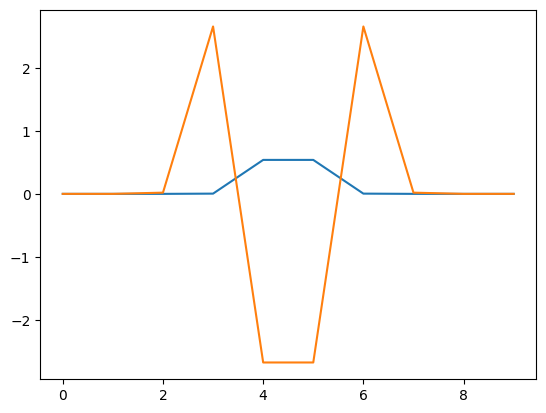

In [ ]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

jjit = jax.jit
# jjit = lambda _: _
ic = lambda *args, **kwargs: None
# from icecream import ic

def learned_dynamics(params):
    @jjit
    def dynamics(q, q_t):
        #     assert q.shape == (2,)
        state = jnp.concatenate([q, q_t])
        out = nn_forward_fn(params, state)
        return jnp.squeeze(out, axis=-1)
    return dynamics

def raw_lagrangian_eom(lagrangian, state, t=None):
    #state is all q, then all q_t.
    vlagrangian = jjit(jax.vmap(lagrangian, (0, 0), 0))

    #Sum Lagrangians for all interacting coordinates.
    @jjit
    def lagrangian_fnc(q, q_t):
        #Assume q is [N,]
        #Move into [q_i-1, q_i, q_i+1]

        q_min = jnp.roll(q, shift=+1)
        q_plus = jnp.roll(q, shift=-1)

        q_t_min = jnp.roll(q_t, shift=+1)
        q_t_plus = jnp.roll(q_t, shift=-1)

        all_q = jnp.stack([q_min, q, q_plus], axis=-1)
        all_q_t = jnp.stack([q_t_min, q_t, q_t_plus], axis=-1)
        ic(all_q.shape, all_q_t.shape)
        return jnp.sum(vlagrangian(all_q, all_q_t))

    @jjit
    def conv_fnc(q, q_t):
        #Assume q is [N,]
        ic(q.shape, q_t.shape)
        q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian_fnc, 1)(q, q_t))
              @ (jax.grad(lagrangian_fnc, 0)(q, q_t)
                 - jax.jacobian(jax.jacobian(lagrangian_fnc, 1), 0)(q, q_t) @ q_t))
        ic(q.shape, q_tt.shape)
        return jnp.array([q_t, q_tt])

    @jjit
    def fnc(state):
        q, q_t = jnp.split(state, 2)

        out = conv_fnc(q, q_t)
        ic(out.shape, 'first')
        out = jnp.concatenate([out[0], out[1]])
        ic(out.shape)
        return out

    return fnc(state)





args = ObjectView({'dataset_size': 200,
 'fps': 10,
 'samples': 100,
 'num_epochs': 80000,
 'seed': 0,
 'loss': 'l1',
 'act': 'softplus',
 'hidden_dim': 400,
 'input_dim': 6, #adjacent points.
 'output_dim': 1,
 'layers': 3,
 'n_updates': 1,
 'lr': 0.001,
 'lr2': 2e-05,
 'dt': 0.1,
 'model': 'gln',
 'batch_size': 512,
 'l2reg': 5.7e-07,
 'gridsize': 10
})
# args = loaded['args']
rng = jax.random.PRNGKey(args.seed)

dx = 0.1

@jit
def analytic_fn(state):
    q, q_t = jnp.split(state, 2)

    q_plus = jnp.roll(q, shift=-1)
    q_min = jnp.roll(q, shift=+1)

    q_x = (q_plus - q_min) / (2 * dx)
    q_xx = (q_plus - 2 * q + q_min) / (2 * dx)

    #Wave equation with constraint:
    q_tt = q_xx
    return jnp.concatenate([q_t, q_tt])

q0 = jnp.exp(-(jnp.linspace(0, 1, num=args.gridsize)-0.5)**2/2/0.05**2)
qt0 = jnp.zeros(args.gridsize)
state0 = jnp.concatenate([q0, qt0])

plt.plot(q0)
plt.plot(analytic_fn(state0)[args.gridsize:])

vfnc = jax.jit(jax.vmap(analytic_fn, 0, 0))

batch = 1
minibatch_per = 5000

@jjit
def get_derivative_dataset(rng):
    # randomly sample inputs
    num = int(args.gridsize/10)

    unsmooth_y0 = jax.random.normal(rng, (batch*minibatch_per, args.gridsize))
    unsmooth_yt0 = jax.random.normal(rng+1, (batch*minibatch_per, args.gridsize))

    y0 = jnp.concatenate([
        sum([jnp.roll(unsmooth_y0, i, axis=1)*2**(-(num/2-i)**2/10) for i in range(num)]),
        sum([jnp.roll(unsmooth_yt0, i, axis=1)*2**(-(num/2-i)**2/10) for i in range(num)])
    ], axis=1)

    return y0, vfnc(y0)

best_params = None
best_loss = np.inf

init_random_params, nn_forward_fn = extended_mlp(args)

nn_forward_fn = nn_forward_fn
_, init_params = init_random_params(rng+1, (-1, args.input_dim))
rng += 1
model = (nn_forward_fn, init_params)
opt_init, opt_update, get_params = optimizers.adam(args.lr)
opt_state = opt_init([[l2/200.0 for l2 in l1] for l1 in init_params])



# train(args, model, data, rng);


@jjit
def loss(params, batch, l2reg):
    state, targets = batch#_rk4
#     leaves, _ = tree_flatten(params)
#     l2_norm = sum(jnp.vdot(param, param) for param in leaves)
    preds = jax.vmap(
        partial(
            raw_lagrangian_eom,
            learned_dynamics(params)))(state)
    ic(preds.shape, targets.shape)
    #preds=(1000, 100, 2), targets=(1000, 200)
    return jnp.sum(jnp.abs(preds - targets))# + l2reg*l2_norm/args.batch_size

@jjit
def update_derivative(i, opt_state, batch, l2reg):
    params = get_params(opt_state)
    param_update = jax.grad(
            lambda *args: loss(*args)/len(batch),
            0
        )(params, batch, l2reg)
#     param_update = normalize_param_update(param_update)
    params = get_params(opt_state)
    return opt_update(i, param_update, opt_state), params


best_small_loss = np.inf
(nn_forward_fn, init_params) = model
iteration = 0
total_epochs = 30
train_losses, test_losses = [], []

nn_forward_fn(init_params, jnp.zeros((10, 6)))

lr = 1e-3 #1e-3



final_div_factor=1e4

#OneCycleLR:
@jjit
def OneCycleLR(pct):
    #Rush it:
    start = 0.3 #0.2
    pct = pct * (1-start) + start
    high, low = lr, lr/final_div_factor

    scale = 1.0 - (jnp.cos(2 * jnp.pi * pct) + 1)/2

    return low + (high - low)*scale


opt_init, opt_update, get_params = optimizers.adam(
    OneCycleLR
)

init_params = custom_init(init_params, seed=1)

opt_state = opt_init(init_params)
# opt_state = opt_init(best_params)
bad_iterations = 0
print(lr)

TRAIN

In [ ]:
epoch = 0

batch_data = get_derivative_dataset(rng)[0][:1000], get_derivative_dataset(rng)[1][:1000]
print(batch_data[0].shape)

loss(init_params, [_x[:1] for _x in batch_data], 0.0)/len(batch_data[0])

update_derivative(0.0, opt_state, [_x[:1] for _x in batch_data], 0.0);

total_epochs = 100

rng += 3

if True:
    for epoch in tqdm(range(epoch, total_epochs)):
        epoch_loss = 0.0
        num_samples = 0
        all_batch_data = get_derivative_dataset(rng)
        for minibatch in range(minibatch_per):
            fraction = (epoch + minibatch/minibatch_per)/total_epochs
            batch_data = (all_batch_data[0][minibatch*batch:(minibatch+1)*batch], all_batch_data[1][minibatch*batch:(minibatch+1)*batch])
            if batch_data[0].shape[0] == 0:
                break
            rng += 10
            opt_state, params = update_derivative(fraction, opt_state, batch_data, 1e-6)
            cur_loss = loss(params, batch_data, 0.0)
            epoch_loss += cur_loss
            num_samples += batch
        closs = epoch_loss/num_samples
        print('epoch={} lr={} loss={}'.format(
            epoch, OneCycleLR(fraction), closs)
             )
        if closs < best_loss:
            best_loss = closs
            best_params = [[copy(jax.device_get(l2)) for l2 in l1] if len(l1) > 0 else () for l1 in params]

(1000, 20)


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored